In [1]:
import numpy as np
from numpy.linalg import norm
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel, SkewedVoigtModel
from slice_spark import cut
from icp import icp
import matplotlib.pyplot as plt

In [2]:
def get_bin_centers(starts, ends, steps):
    """
        To get the bin centers
        @paras:
            starts: [H_start, K_start, L_start, energy_start]
            ends: [H_end, K_end, L_end, energy_end]
            steps: [H_step, K_step, L_step, energy_step]
        @returns:
            bin_centers: List of arrays, format:
            [[H_bin_centers], [K_bin_centers], [L_bin_centers], [energy_bin_centers]].
    """
    return np.arange(starts+0.5*steps, ends-0.5*steps+1e-5, steps)

# test:
#QE_info = np.array([[-3.5, -2.5, 0.02], [-3.1, -2.9, 0], [-1.1, -0.9, 0], [-4, 4, 0]])
#print(QE_info)
#print(get_bin_centers(*QE_info[0]))

In [3]:
def fit_1peak_1direction(infile, pos, cut_length, cut_width, cut_thickness, \
        energy_window, ix_direction, model_name, verbose=False):
    """
    To fit the peaks along one direction.
    @paras:
        infile: the dataset file path.
        pos: [H0, K0, L0] the initial postion of the peak
        cut_length, cut_width, cut_thickness, energy_window, ix_direction:
            All these are cutting setting.
            For example, if given
            ----------------------------------
            pos = [1, 2, 3], cut_length=1, cut_width=0.05, cut_thickness=0.2, 
            energy_window=4, ix_direction=2.
            ----------------------------------
            These will make cuts along [0K0] directions, giving the slice as
            H: [0.9, 1.1]            #cut_thickness=1.1-0.9=0.2
            K: [1.5, 2.5, step=0.05] #cut_length=2.5-1.5=1, cut_width=step=0.05
            L: [2.9, 3.1]            #cut_thickness=3.1-2.9=0.2
            energy: [-2, 2]          #energy_window=2-(-2)=4meV
        model_name: the name of the model to fit the peak. Default: Gaussian.
            Options: Gaussian, Lorentzian, Voigt, SkewedVoigt. 
            Only the first letter in the name matters.
        verbose: print/save the fitting curves: Default: False.
    @returns:
        the peak position along that direction
    """
    
    """
    To gather the information to make cut of the data. Format:
    QE_info: list or numpy array
            [[H_start, H_end, H_step],
             [K_start, K_end, K_step],
             [L_start, L_end, L_step],
             [energy_start, energy_end, energy_step]]
            If no step value or the step value is 0, means only one bin 
            [start, end) for that component.
    """
    QE_info = np.zeros((4, 3))
    QE_info[:3, 0] = pos
    QE_info[:3, 1] = pos
    tmp = 0.5 * np.array([cut_length if i == ix_direction else cut_thickness for i in range(3)])
    QE_info[:3, 0] -= tmp
    QE_info[:3, 1] += tmp
    QE_info[ix_direction, 2] = cut_width
    QE_info[3, 0] = -0.5*energy_window
    QE_info[3, 1] = 0.5*energy_window
    
    # cut
    y = cut(infile, QE_info)
    x = get_bin_centers(*QE_info[ix_direction])
    
    # fit the peak
    flag = model_name[0].upper()
    if  flag == 'G':
        mod = GaussianModel()
    elif flag == 'L':
        mod = LorentzianModel()
    elif flag == 'V':
        mod = VoigtModel()
    elif flag == 'S':
        mod = SkewedVoigtModel()
    else:
        print('cannot identify the model name, use Gaussain model anyway...')
        mod = GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    
    if verbose:
        plt.scatter(x, y, c='b')
        plt.plot(x, out.best_fit, 'r-')
        plt.show()
        plt.close()
    
    return pars.valuesdict()['center'] # return the center of the peak

# test: QE_info = [[-3.5, -2.5, 0.02], [-3.1, -2.9], [-1.1, -0.9], [-4, 4]]
#infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
#pos = np.array([-3, -3, -1])
#print(fit_1peak_1direction(infile, pos, 1, 0.02, 0.2, 8, 0, 's', verbose=True))

iter 1, direction X:


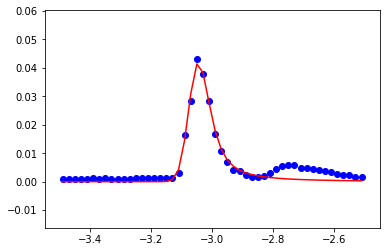

iter 1, direction Y:


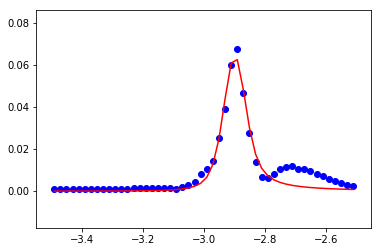

iter 1, direction Z:


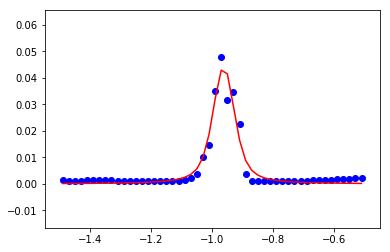

[-3.04 -2.9  -0.96]
iter 2, direction X:


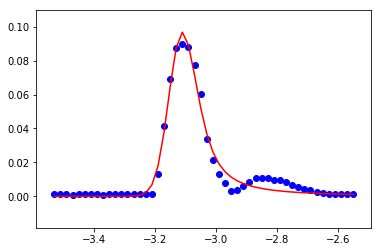

iter 2, direction Y:


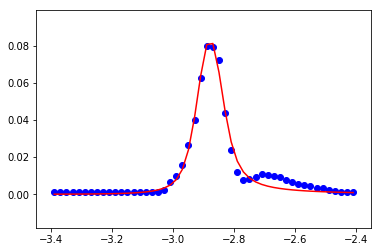

iter 2, direction Z:


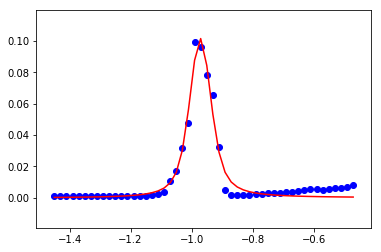

[-3.1  -2.87 -0.96]
iter 3, direction X:


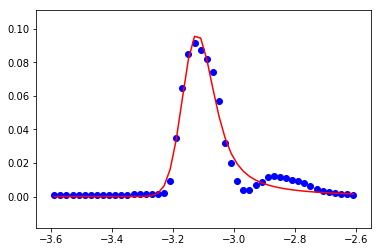

iter 3, direction Y:


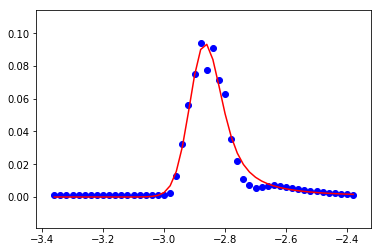

iter 3, direction Z:


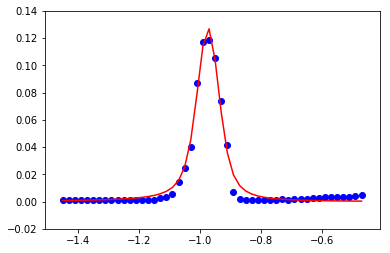

[-3.11 -2.86 -0.97]


In [5]:
def get_1peak_position(infile, pos, cut_length, cut_width, cut_thickness, \
        energy_window, model_name, threshold=0, verbose=False, max_iterations=10):
    """
    To get the position of one peak.
    """
    
    pre_pos = np.array(pos)
    direction = ['X', 'Y', 'Z']
    
    # If the user didn't specify the threshold, use cut_width.
    if not threshold:
        threshold = cut_width
        
    for i in range(max_iterations):
        post_pos = np.zeros(3)
        
        # update the position
        for ix_direction in range(3):
            print("iter {}, direction {}:".format(i+1, direction[ix_direction]))
            post_pos[ix_direction] = fit_1peak_1direction(infile, pre_pos, cut_length, \
                cut_width, cut_thickness, energy_window, ix_direction, model_name, verbose)
                
        # check the changes
        if norm(post_pos - pre_pos) <= threshold:
            return post_pos
        else:
            print(post_pos)
            pre_pos = post_pos
    return False # cannot get a good fitting result

# test: QE_info = [[-3.5, -2.5, 0.02], [-3.1, -2.9], [-1.1, -0.9], [-4, 4]]
infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
pos = np.array([-3, -3, -1])
print(get_1peak_position(infile, pos, 1, 0.02, 0.2, 8, 's', verbose=True))

In [6]:
def get_braggpeaks_position(infile, ideal_positions, cut_length, cut_width, \
        cut_thickness, energy_window, model_name='', search_limit=0.5, verbose=False):
    """
    To get the positions of bragg peaks in the data set.
    @paras:
        I: the dataset
        ideal_positions: ideal positions. Also these are the initial positions
            we start to look for the bragg peaks.
        search_limit: the search limit to get the bragg peaks. Default: 0.5. 
            For example, if we search for a bragg peaks near [0, 0, 0]. We will
            drop the result if we find the peak is at [0.6, 0.55, 0.6].
    @returns:
        The positions of "good" peaks.
    """
    ix_bad_peaks, good_peaks = [], []
    for i, pos in enumerate(ideal_positions):
        real_pos = get_1peak_position(infile, pos, cut_length, cut_width, cut_thickness, energy_window, model_name, verbose)
        if real_pos and np.amax(np.abs(real_pos-pos)) < search_limit:
            good_peaks.append(real_pos)
        else:
            ix_bad_peaks.append(i)
    print('list of peaks that are not found:', ix_bad_peaks)
    return good_peaks